Imports

In [1]:
import torch
import brian2 as b2
from brian2 import *
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt
from pprint import pprint
import pickle


from torch.utils.data import Dataset, DataLoader

from dataset_util import Synthetic_Dataset_Utils


import brian2genn



set_device('genn', use_GPU=True)


msec_step = 100
shared_clock = Clock(dt=msec_step*ms)


set_device('genn', use_GPU=True)

INFO       The following preferences have been changed for Brian2GeNN, reset them manually if you use a different device later in the same script: codegen.loop_invariant_optimisations, core.network.default_schedule [brian2.devices.genn]


# Adex neuron dynamics

In [10]:
# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)

# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iinh - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp 
Iinh : amp 
batch_sum_X : 1  # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''
# Ii = I + input_stimuli(t)  :  amp  # Input current



# Equations

### *original equations*

In [2]:

input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, indices) : amp
indices : integer 
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp # Synaptic input 
Iexc2 : amp # Synaptic input 
I_tot = Iexc + Iexc2 + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
w : siemens  # Synaptic weight (conductance)
Iexc_post = w * X_pre : amp (summed)
'''

syn_eqs_exc_output = '''
w : siemens  # Synaptic weight (conductance)
Iexc2_post = w * X_pre : amp (summed)
'''

syn_eqs_inh= '''
w : siemens  # Synaptic weight (conductance)
Iinh_post = w * X_pre : amp (summed)
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation

In [2]:
# TODO: Make weights always non-negative!


# Equations for everything. I_post in the synapse is modifying I in the target neuron


# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold

DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential

Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)



eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + Iexc + Iinh - A ) / Cm : volt 
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay 
Iexc : amp
Iinh : amp
batch_sum_X : 1   # Accumulate X values over a batch
running_sum_X : 1  # Sum of X during a stimulus
'''

input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt 
dA/dt = (c * (v - EL) - A) / tau_A : amp 
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
I = input_stimuli(t, indices) : amp
indices : integer
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT)
          + Iexc + Iexc2 + output_stimuli(t, indices) - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
dX/dt = -X / tau_decay + Y / tau_rise : volt    # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
Iexc : amp  # Synaptic input
Iexc2 : amp # Synaptic input
indices : integer
'''

syn_eqs_exc = '''
w : siemens   # Synaptic weight, conductance
Iexc_post += w * X_pre : amp (summed)
'''

exc_output = '''
w : siemens   # Synaptic weight, conductance
Iexc2_post += w * X_pre : amp (summed)
'''

syn_eqs_inh = '''
w : siemens   # Synaptic weight, conductance
Iinh_post += w * X_pre : amp (summed)
'''



### *STDP*

In [3]:
#stdp parameters
sigma = 0.3                                                                                                                                                                                                             
taupre = 5*ms
taupost = 8*ms
wmax = 1.2
wmin = -0.5
Apre = 0.4*sigma
Apost = -0.2*sigma

#characteristics of neurons
tau = tau_A
vr = Vr
vt = 1.5*mV

### *Hebbian*

# Functions

### Creating network architecture and connections

In [4]:


gist_dim = 16


def make_groups(dims, eqs = eqs, with_input = False):
    """
    Just a function to make neurongroups of specified dimension. Assigns input equations (which read the input timedarray, hopefully) 
    to the first group if with_input = True
    """

    groups = []

    for i, dim in enumerate(dims):
    
        if i == 0 and with_input == True:
    
            groups.append(NeuronGroup(dim, input_eqs, threshold='v > Vcut', reset='v = Vr', method='euler'))
    
        else:
    
            groups.append(NeuronGroup(dim, eqs, threshold='v > Vcut', reset='v = Vr', method='euler'))
    
    for group in groups:
        
        group.v = EL
    
    
    return groups

def make_bottom_up_connections(R, E_0, E_1, syn_eqs_exc, syn_eqs_inh):


  S_p = Synapses(R, E_0, model=syn_eqs_exc,
        on_pre='Y_post = 1*volt ')

    
  S_p.connect(condition='i == j')  # One-to-one connections
  S_p.w = 'w_init'


  S_m = Synapses(R, E_1, model=syn_eqs_inh,
        on_pre='Y_post = 1*volt')
  S_m.connect(condition='i == j')  # One-to-one connections
  S_m.w = 'w_init'

  return S_p, S_m
def make_top_down_connections(R, E_0, E_1, syn_eqs_exc, syn_eqs_inh):


  S_p = Synapses(R, E_1, model=syn_eqs_exc,
        on_pre='Y_post = 1*volt')
  S_p.connect()
  S_p.w = 'rand() * w_init'


  S_m = Synapses(R, E_0, model=syn_eqs_inh,
        on_pre='Y_post = 1*volt')
  S_m.connect()
  S_m.w = 'rand() * w_init'


  return S_p, S_m

def make_gist_connections(Rs, G):

  S = Synapses(Rs[0], G, model=syn_eqs_exc,
        on_pre='Y_post = 1*volt')
  S.connect(p=0.05)  # Connect with 5% probability
  S.w = 'rand() * w_init'   # This is slightly different from the paper: it should be based on a ratio

  S_gist_input = S

  for R in Rs[1:]:
    S = Synapses(G, R, model=syn_eqs_exc,
        on_pre='Y_post = 1*volt')
    S.connect(p=0.05)  # Connect with 5% probability
    S_gist_output = S

  return S_gist_input, S_gist_output
# num_classes_per_layer and max_depth depend on the same parameters used when generating the datset


def make_output_layer(num_classes_per_layer, max_depth, w_out_init = None ):

    if w_out_init == None:
        w_out_init = w_init/10
        
        

    total_neurons = sum([num_classes_per_layer**(d+1) for d in range(max_depth)])
    
    
    Os = NeuronGroup(N=total_neurons, model = out_eqs, threshold='v > Vcut', reset='v = Vr', method='euler')

    

    S_o = Synapses(Os, Os, model=syn_eqs_exc_output, on_pre='Y_post = 1*volt')
    
    trace = 0
    for d in range(num_classes_per_layer - 1):

        new_trace = trace + num_classes_per_layer**(d+1)
        
        source_indices = list(range(trace, trace + num_classes_per_layer**(d+1)))
        target_indices = list(range(new_trace , new_trace + num_classes_per_layer**(d+2)))

        ii, jj = np.meshgrid(source_indices, target_indices, indexing='ij')
        
        S_o.connect(i=ii.flatten(), j=jj.flatten())

        trace = new_trace


    stimulus_indices = []

    for i, n in enumerate([num_classes_per_layer**i for i in range(1, max_depth+1)]):
        for _ in range(n):
            stimulus_indices.append(int(i))
            
    Os.indices = stimulus_indices 


    return Os, S_o


### Main function compiling network

In [5]:

def make_network(dims, syn_eqs_exc, syn_eqs_inh, num_classes_per_layer, max_depth, w_out_init = None ):

    max_depth += 1
    
    Rs = make_groups(dims, with_input = True)
    Es_0 = make_groups(dims[:-1])
    Es_1 = make_groups(dims[:-1])
    G = NeuronGroup(gist_dim, eqs, threshold='v > Vcut', reset='v = Vr', method='euler')
    
    Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth) # Hopefully this is correct
    
    connections = {}
    connections["output_internal"] = S_o_internal
    
    for i in range(len(Rs)-1):
    
    
        S_p, S_m = make_bottom_up_connections(Rs[i], Es_0[i], Es_1[i], syn_eqs_exc, syn_eqs_inh)
        
        connections[f"bottom_up_{i}"] = [S_p, S_m]
    
        if i != len(Rs)-1:
        
            S_p, S_m = make_top_down_connections(Rs[i+1], Es_0[i], Es_1[i], syn_eqs_exc, syn_eqs_inh)
            
            connections[f"top_down_{i}"] = [S_p, S_m]
        
    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    
    connections["gist_input"] = S_gist_input
    connections["gist_output"] = S_gist_output
    
    '''
    S_o_external = Synapses(Rs[-1], Os, model=syn_eqs_exc,
        on_pre='Y_post = 1*volt')
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    '''
    S_o_external = []
    for O in Os:
        S = Synapses(Rs[-1], O, model=syn_eqs_exc, on_pre='Y_post = 1*volt')
        S.connect()
        S.w = 'rand() * w_init'
        S_o_external.append(S)
    connections["output_external"] = S_o_external


    return Rs, Es_0, Es_1, G, S_gist_input, S_gist_output, Os, S_o_external, connections





### prepping input for network

In [6]:
#normalizing input

def normalize_tensor(tensor, old_min, old_max, new_min, new_max):

    normalized_tensor = (tensor - old_min) / (old_max - old_min)


    scaled_tensor = normalized_tensor * (new_max - new_min) + new_min

    return scaled_tensor


#split key (label of the curve/graph which is the input) and curve

def normalize_and_unwrap_dataset(dt, minval,maxval):


    minimum = 0
    maximum = 0
    
    all_curves = [torch.tensor(curve, dtype = torch.float64) for curve in chain.from_iterable(dt["curves"].values())]
    
    for curve in all_curves:
    
        _min = torch.min(curve)
        _max = torch.max(curve)
        if(minimum > _min): minimum = _min
        if(maximum < _max): maximum = _max


    unwrapped = []
    for key in dt["categories"].keys():
        for curve in dt["curves"][key]:
            unwrapped.append((torch.tensor(key), normalize_tensor(torch.tensor(curve), minimum, maximum, minval, maxval)))
            
    return unwrapped
            
def get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer):

    if labels.ndim == 1:
        labels = labels.unsqueeze(0)  # Convert to 2D with shape (1, len(I_indexes))

    indexes = torch.zeros_like(labels)
    
    for i in range(0, labels.shape[1]):
    
        summed = 0
        if i>0:
            summed = torch.stack([labels[:,j]*num_classes_per_layer**(i-j) for j in range(i)]).sum(dim=0)
    
        indexes[:,i] = summed + labels[:,i] # These are more intelligible, since they indicate which neuron to stimulate for each level of granularity

    # But we need to adapt them for a situation where all neurons are concatenated in a single list
    
    to_sum = 0
    for i in range(0, labels.shape[1]):

        if i>0:
            to_sum += num_classes_per_layer**i 

        indexes[:,i] = indexes[:,i] + to_sum

    return indexes



def get_output_current_arrays(I_indexes, dim, I_value):
    # Ensure I_indexes is 2D for consistent processing
    if I_indexes.ndim == 1:
        I_indexes = I_indexes.unsqueeze(0)  # Convert to 2D with shape (1, len(I_indexes))

    # Create an output tensor of zeros
    out = torch.zeros((I_indexes.shape[0], dim), dtype=torch.float32)

    # Row indices (batch indices) for advanced indexing
    row_indices = torch.arange(I_indexes.shape[0]).repeat_interleave(I_indexes.shape[1])

    # Flattened column indices (curve indexes)
    col_indices = I_indexes.flatten()

    # Set the values using advanced indexing
    out[row_indices, col_indices] = I_value

    return out


class CurveDataset(Dataset):
    def __init__(self, data, minval, maxval):
        
        self.data = normalize_and_unwrap_dataset(data, minval, maxval)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        labels, curves = self.data[idx]
      
  
        return labels, curves.flatten()



def collate_fn(batch, msec_step, num_pause_blocks, num_classes_per_layer, out_dim):

    

    labels, curves = zip(*batch)

    labels = torch.stack(labels, dim=0)
    curves = torch.stack(curves, dim=0)


   
    pause = torch.zeros_like(curves[0])  
    
    pause_block = torch.tile(pause, (num_pause_blocks, 1))  
    
    # Interleave stimulus rows with the pause block
    curves_with_pause = torch.vstack([torch.vstack((row, pause_block)) for row in curves])

    visual_stimulus = TimedArray(curves_with_pause.numpy() * nA, dt=msec_step*ms)


    stimulus_indexes = TimedArray(np.tile([1] +
                                     [0] * num_pause_blocks, curves.size(0)), dt=msec_step*ms)
    




    out_stimuli_idx = get_output_stimuli_indexes_from_labels(labels, num_classes_per_layer)
   
    out_stimuli_array = get_output_current_arrays(out_stimuli_idx, out_dim, 1)

    label_pause = torch.zeros(out_dim)  
    
    label_pause_block = torch.tile(label_pause, (num_pause_blocks, 1)) 

    out_stimuli_with_pause = torch.vstack([torch.vstack((row, label_pause_block)) for row in out_stimuli_array])

    output_stimuli = TimedArray(out_stimuli_with_pause.numpy() * nA, dt=msec_step*ms) 
    

 
    

    return stimulus_indexes, output_stimuli , visual_stimulus, labels

# Main script

### settings for network

In [7]:
#Es layers:    Error layers
#S_o_external: connecting last RS with output layer
#Os:            output layer

dims = [10, 6,6,3]
Rs, Es_0, Es_1, G, S_gist_input, S_gist_output, Os, S_o_external, connections = make_network(dims, syn_eqs_exc, syn_eqs_inh, num_classes_per_layer=3, max_depth=3)


Rs[0].indices = range(Rs[0].N)

NameError: name 'syn_eqs_exc_output' is not defined

data set import

In [ ]:
su = Synthetic_Dataset_Utils()

ranges = [30,30,30,30]  # Ranges for each parameter

prior_params = [10,10,10,10]  # Initial parameters

num_samples_per_class=5
N=15

# Build the tree
max_depth = 3 # Adjust as needed
num_classes_per_layer = 3  # Adjust as needed

std_multiplier = 1

tree = su.build_tree(prior_params, 0, max_depth, num_classes_per_layer, std_multiplier, ranges)

synth_dataset = su.make_dataset(tree, num_samples_per_class=num_samples_per_class, N=N)

### settings and loading dataset

In [ ]:
output_dim = sum([len(o) for o in Os])

lr = 0.03
msec_step = 500
batch_size = 20
num_pause_blocks = 1

dataset = CurveDataset(synth_dataset, 0.6, 1.5)
dl = DataLoader( dataset, shuffle = True, batch_size = batch_size, collate_fn = partial(collate_fn, msec_step=msec_step, num_pause_blocks=num_pause_blocks,
                                                                                num_classes_per_layer = num_classes_per_layer, out_dim = output_dim) )

### functions for updating while running the network

In [ ]:
# Update logic
@network_operation()
def add_inputs():
    stimulus_indexes = _stimulus_indexes 
    output_stimuli = _output_stimuli
    input_stimuli = _input_stimuli

@network_operation()
def debug():
    print("Rs[0].I: ", Rs[0].I[:])
   
@network_operation()
def update_sums():

    current_idx = int(defaultclock.t / msec_step*ms)
    
    if stimulus_indexes.values[current_idx] == 1:

        
        for n in range(len(Rs)-1):

            if n > 0:
                Rs[n+1].batch_sum_X += Rs[n+1].X_
                
            Es_0[n].batch_sum_X += Es_0[n].X_
            Es_1[n].batch_sum_X += Es_1[n].X_

#function to train network by inputting the same input into the output layers
@network_operation()
def apply_weight_update():
    
    print("Applying weight update")
    
    for n in range(len(Rs)-1):

        print("n: ", n)
        
        for i in range(len(Rs[n+1])):
            for j in range(len(Es_0[n])):
   
            
                S_p, S_m = connections[f"top_down_{n}"]
    
                S_p.w[i,j] += lr * Es_0[n].batch_sum_X[j] * Rs[n+1].batch_sum_X[i] * siemens
                
                S_m.w[i,j] += lr * Es_1[n].batch_sum_X[j] * Rs[n+1].batch_sum_X[i]  * siemens
            
                Rs[n+1].batch_sum_X[i] = 0
                
                Es_0[n].batch_sum_X[i]= 0
    
                Es_1[n].batch_sum_X[i] = 0



# Training

In [ ]:
#variables to extract from data set
stimulus_indexes, output_stimuli, input_stimuli, labels = next(iter(dl))


In [ ]:
start_scope()

monitor = StateMonitor(Rs[0], ['v', 'I'], record=[0]) #membrane volage of first neuron group
spike_monitor_input = SpikeMonitor(Rs[0]) #spikes from input neurons
spike_monitor_output = SpikeMonitor(Rs[3]) #spikes from output neurons

net = Network(Rs, Es_0, Es_1, G,  Os, connections, monitor, spike_monitor_input, spike_monitor_output, add_inputs, debug, update_sums, apply_weight_update)

lable_list = []

for i, (_stimulus_indexes, _output_stimuli, _input_stimuli, labels) in enumerate(dl):
    #print(labels)
    print(f"batch n.{i}")
    lable_list.append(labels)

    net.run((batch_size + batch_size*num_pause_blocks) * 100 * ms)



In [ ]:
#save the network

#variables to save

save_data = {
    'Rs': [group.get_states() for group in Rs],  # Save neuron group states
    'connections': [conn.get_states(['w']) for conn in connections],  # Save synaptic weights
    'Es_0': Es_0.get_states(),  # Save state monitors
    'Es_1': Es_1.get_states(),
    'parameters': {
        'gL': gL,
        'EL': EL,
        'DeltaT': DeltaT,
        'Cm': Cm,
    },  # Add other parameters as needed
}

# Save to a file
with open('trained_network.pkl', 'wb') as f:
    pickle.dumps(save_data, f)

print("Network saved successfully!")


laod the network

In [ ]:
# Load from the file
with open('trained_network.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract components
Rs = loaded_data['Rs']
Es_0 = loaded_data['Es_0']
Es_1 = loaded_data['Es_1']
G = loaded_data['G']
Os = loaded_data['Os']
connections = loaded_data['connections']
monitor = loaded_data['monitor']
spike_monitor_input = loaded_data['spike_monitor_input']
spike_monitor_output = loaded_data['spike_monitor_output']

# Rebuild the network
net = Network(Rs, Es_0, Es_1, G, Os, connections, monitor, spike_monitor_input, spike_monitor_output)
print("Network loaded successfully!")


# Evaluation

### Decoding the class from the spike trains

In [8]:
#Os

# visualizing

### accuracy

### granuality

In [9]:
pprint(vars(spike_monitor_input))
pprint(vars(spike_monitor_output))

NameError: name 'spike_monitor_input' is not defined

NameError: name 'spike_monitor' is not defined

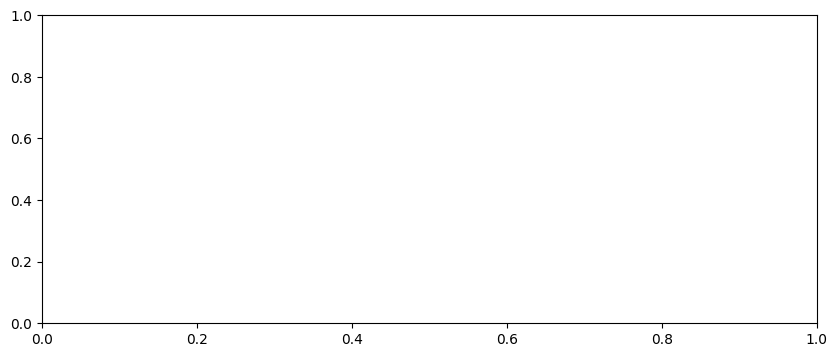

In [10]:
plt.figure(figsize=(10, 4))



# Firing rate plot
plt.subplot(1, 1, 1)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()




In [ ]:
def training_phase_1(network, dl):

  for label_input, curve_input, labels in dl:
    ...

In [ ]:

plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='mV')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Input')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Input')

plt.tight_layout()
plt.show()



## Other

In [ ]:
"""

network = Network(
    *Rs,        # Unpack the list of NeuronGroups
    *Es_0,      # Unpack the list of NeuronGroups
    *Es_1,      # Unpack the list of NeuronGroups
    G,          # Single NeuronGroup is fine
    Os,         # Single NeuronGroup is fine
    connections["output_internal"],   # Single Synapses object is fine
    connections["gist_input"],        # Single Synapses object is fine
    *connections["gist_output"],      # Unpack the list of Synapses
    *connections["output_external"],  # Unpack the list of Synapses
    spike_monitor, 
    monitor,
    debug, 
    update_sums, 
    apply_weight_update
)

eqs_neuron = '''
dv/dt = (-gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = stimulus(t)  : amp  
'''


neuron = make_groups([1], eqs = eqs_neuron)[0]

neuron

# Change 2 to any value from 0.6 to 1.5, which is the range of current intensity we are probably going to use

stimulus = TimedArray(np.hstack([[c] for c in np.ones(1)*0.8]) * nA, dt=10*ms)



neuron.v = EL
neuron.A = 0 * nA

# Monitor the specific neuron (neuron 2)
monitor = StateMonitor(neuron, ['v', 'I'], record=[0])
spike_monitor = SpikeMonitor(neuron)

run(1 * second)

# Plot membrane potential
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

# Membrane potential plot
plt.subplot(2, 1, 1)
plt.plot(monitor.t / ms, monitor.v[0] / mV, label='Neuron 2 Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Stimulus Applied to Single Neuron')
plt.legend()

# Firing rate plot
plt.subplot(2, 1, 2)
plt.hist(spike_monitor.t / ms, bins=10, alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Firing Rate of Neuron 2')

plt.tight_layout()
plt.show()



'''
0.6: 0
0.625: 0
0.63: 0.5
0.65: 1.5
0.7: 2.8
0.8: 4.5
1: 7.5
1.5: 14
2: 20
'''
# Let's connect 2 groups as a trial

G1 = NeuronGroup(5, 'v : volt', threshold='v > Vcut', reset='v = Vr', method='euler')  # Presynaptic neurons
G2 = NeuronGroup(5, eqs, threshold='v > Vcut', reset='v = Vr; A += b', method='euler')  # Postsynaptic neurons

# Initialize variables
G1.v = EL
G2.v = EL
G2.A = 0 * nA

# Create synapses
S = Synapses(G1, G2, model=syn_eqs_exc,
             on_pre='Y_post = 1*volt', method = "euler")  # Increment glutamate release on spike
S.connect(p=0.1)  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

# Monitors
spike_mon_G1 = SpikeMonitor(G1)
spike_mon_G2 = SpikeMonitor(G2)
state_mon_G2 = StateMonitor(G2, ['v', 'I', 'A'], record=True)

# Run simulation
b2.run(500 * ms)

plt.figure(figsize=(12, 6))

# Plot membrane potential of a postsynaptic neuron
plt.subplot(311)
plt.plot(state_mon_G2.t / ms, state_mon_G2.v[0] / mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()


plt.tight_layout()
plt.show()
# TODO: Make weights always non-negative!

# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold
DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential
Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)

# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Input current
'''

input_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I = input_stimuli(t)  : amp  
'''

out_eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I_tot - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp
I : amp  # Synaptic input (summed)
I_tot = I + output_stimuli(t, indices) : amp
indices : integer  # dimensionless index variable
'''

# Synapse equations (Spike trace dynamics)


syn_eqs_exc = '''
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

syn_eqs_inh= '''
dX/dt = -X / tau_decay + Y / tau_rise : volt  # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
batch_sum_X : volt  # Accumulate X values over a batch
running_sum_X : volt  # Sum of X during a stimulus
'''

def update_batch_sum(synapses):
    synapses.batch_sum_X += synapses.X  # Perform the operation
# Update logic
@network_operation(dt = batch_size * msec_step * ms)
def update_sums( ):

    current_idx = int(defaultclock.t / msec_step*ms)
    
    if stimulus_indexes.values[current_idx] == 1:

        
        for n in range(len(Rs)-1):

            for i in range(len(Rs[n])):
 
                '''
                Rs[n].batch_sum_X[i] += Rs[n].X_[i]
                
                Es_0[n].batch_sum_X[i] += Es_0[n].X_[i]
    
                Es_1[n].batch_sum_X[i] += Es_1[n].X_[i]
                '''

                Rs[n].batch_sum_X += Rs[n].X_
                Es_0[n].batch_sum_X += Es_0[n].X_
                Es_1[n].batch_sum_X += Es_1[n].X_
        
            
@network_operation( dt = batch_size * msec_step * ms )
def apply_weight_update():
    
    print("Applying weight update")
    
    for n in range(len(Rs)-1):
        print("n: ", n)
        
        for i in range(len(Rs[n])):
            print("i: ", i)
            for j in range(len(Es_0[n])):
                print("j: ", j)
    
            
                S_p, S_m = connections[f"top_down_{n}"]
    
                S_p.w[i,j] += lr * Es_0[n].batch_sum_X[j] * Rs[n].batch_sum_X[i] * siemens
                
                S_m.w[i,j] += lr * Es_1[n].batch_sum_X[j] * Rs[n].batch_sum_X[i]  * siemens
            
                Rs[n].batch_sum_X[i] = 0
                
                Es_0[n].batch_sum_X[i]= 0
    
                Es_1[n].batch_sum_X[i] = 0



for stimulus_indexes, output_stimuli, input_stimuli in dl:

    print("indexes", stimulus_indexes.values.shape, stimulus_indexes.values)

    run((batch_size + batch_size*num_pause_blocks) * 100 * ms)

    
    """